In [9]:
import numpy as np
from nbodykit.algorithms.fftpower import FFTPower
from nbodykit.source.catalog import ArrayCatalog
import matplotlib.pyplot as plt
from os.path import join as pjoin
import Pk_library as PKL
import MAS_library as MASL
from summarizer.data import Catalogue
from tqdm import tqdm

Check Summarizer code

/tmp/ipykernel_244093/2184936150.py:21: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_mock = cat.to_mesh(window='cic', Nmesh=n_grid, compensated=True, position='Position')
/tmp/ipykernel_244093/2184936150.py:43: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_mock = nblab_cat.to_mesh(window='cic', Nmesh=n_grid, compensated=True, position='Position')


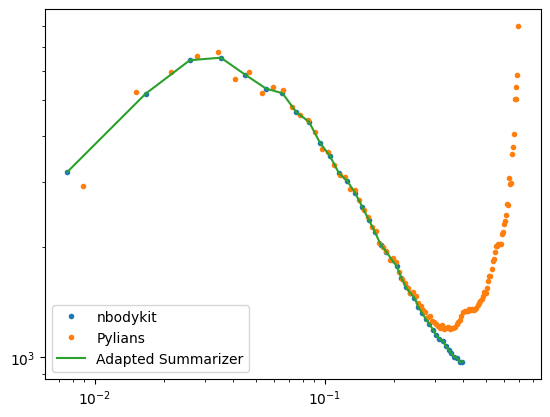

In [20]:
dirname = '/home/mattho/git/ltu-cmass/data/calib_1gpch_z0.5/borg2lpt/L1000-N128/'
params_file = '/home/mattho/data/quijote/latin_hypercube_params.txt'
sim_num = 136

n_grid = 128
boxsize = 1000.
redshift = 0.5
    
df_nbkit = {}

x = np.load(pjoin(dirname, str(sim_num), 'halo_pos.npy'))

# Get cosmological parameters
header = ['Omega_m', 'Omega_b', 'h', 'n_s', 'sigma_8']
lh_pars = np.loadtxt(params_file)
cosmo_dict = {k:v for k, v in zip(header, lh_pars[sim_num,:])}

# Nbodykit
df_nbkit['Position'] = x
cat = ArrayCatalog(df_nbkit, BoxSize=boxsize)
mesh_mock = cat.to_mesh(window='cic', Nmesh=n_grid, compensated=True, position='Position')
r = FFTPower(mesh_mock, mode='1d', dk=0.01)
Pk_mock_nb = r.power
plt.loglog(Pk_mock_nb['k'], Pk_mock_nb['power'].real, '.', label='nbodykit')

# Pylians
MAS = "CIC"
delta = np.zeros((n_grid,n_grid,n_grid), dtype=np.float32)
MASL.MA(x.astype(np.float32), delta, boxsize, MAS, verbose=False)
delta /= np.mean(delta, dtype=np.float64)
delta -= 1.0
Pk = PKL.Pk(delta.astype(np.float32), boxsize, axis=0, MAS=MAS, threads=1, verbose=False)
k3D      = Pk.k3D
Pk3D     = Pk.Pk[:,0]
plt.loglog(k3D, Pk3D, '.', label='Pylians')

# Summarizer
pos = np.load(pjoin(dirname, str(sim_num), 'halo_pos.npy'))
vel = np.load(pjoin(dirname, str(sim_num), 'halo_vel.npy'))
mass = 10. ** np.load(pjoin(dirname, str(sim_num), 'halo_mass.npy'))
catalogue = Catalogue(pos, vel, redshift, boxsize, cosmo_dict, 'test', mass=mass, mesh=False)
nblab_cat = catalogue.to_nbodykit_catalogue(weights=None)
mesh_mock = nblab_cat.to_mesh(window='cic', Nmesh=n_grid, compensated=True, position='Position')
r = FFTPower(mesh_mock, mode='1d', dk=0.01)
Pk_mock_nb = r.power
plt.loglog(Pk_mock_nb['k'], Pk_mock_nb['power'].real, '-', label='Adapted Summarizer')

plt.legend()

Power spectrum comparison

  0%|          | 0/10 [00:00<?, ?it/s]/tmp/ipykernel_817200/3581860972.py:46: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_mock = cat.to_mesh(window='nearest', Nmesh=n_grid, compensated=False, position='Position')
/tmp/ipykernel_817200/3581860972.py:48: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_mock = cat.to_mesh(window='nearest', Nmesh=n_grid, compensated=False, position='Position', weight=weight)
100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


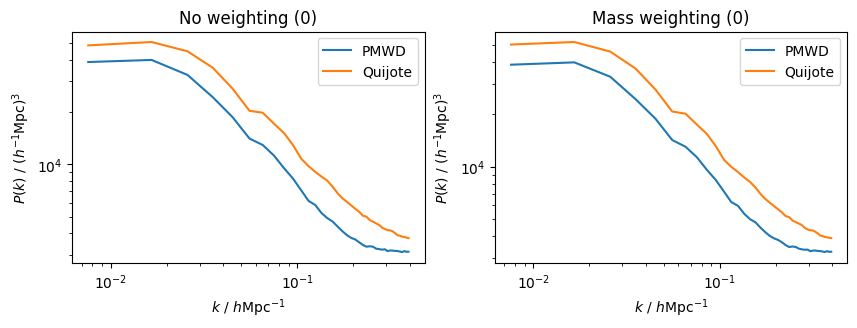

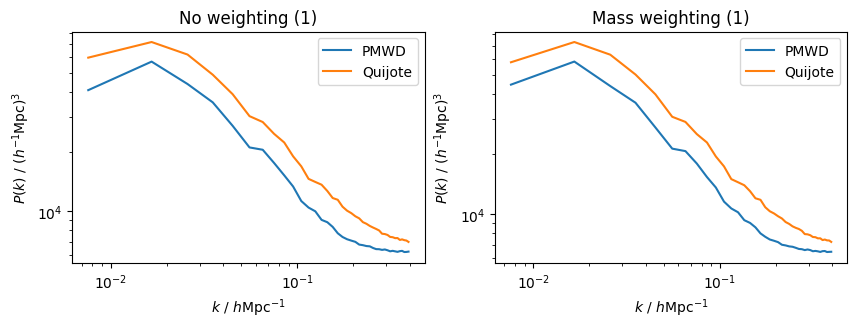

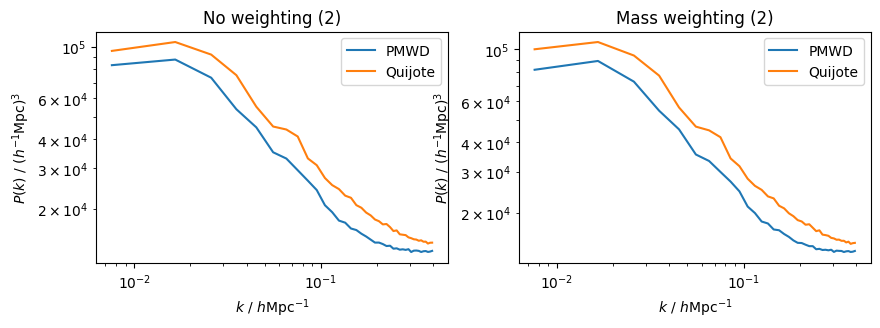

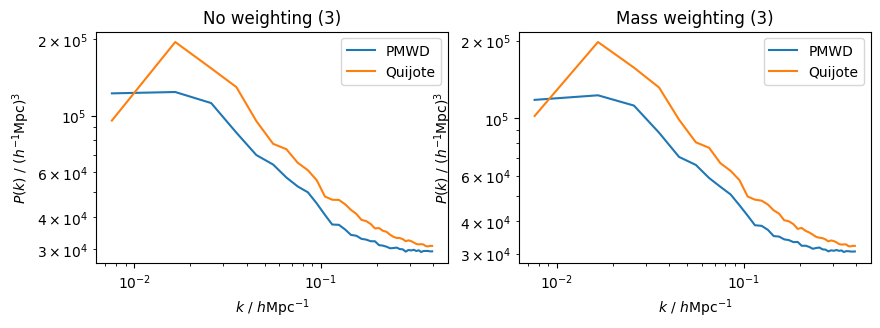

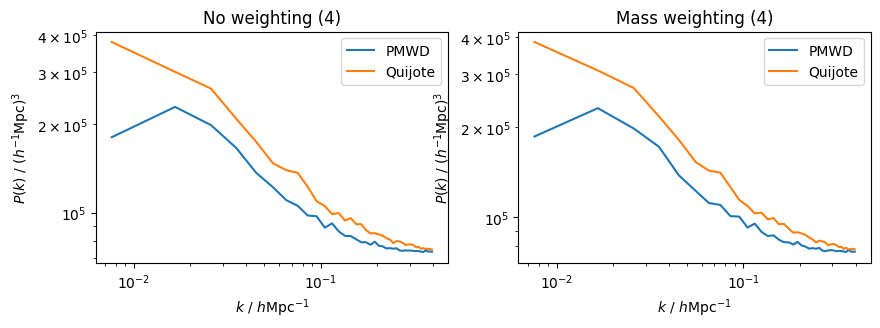

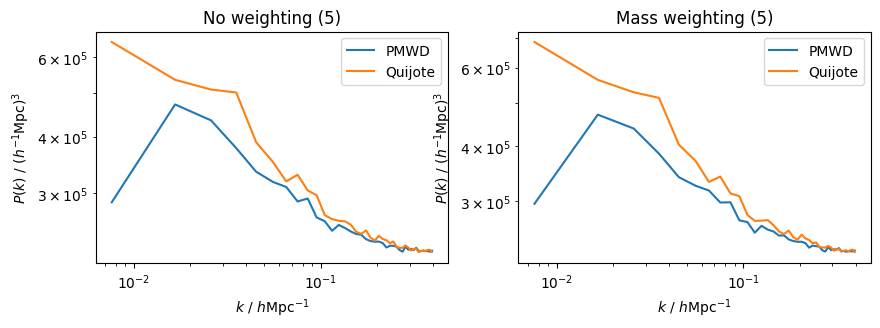

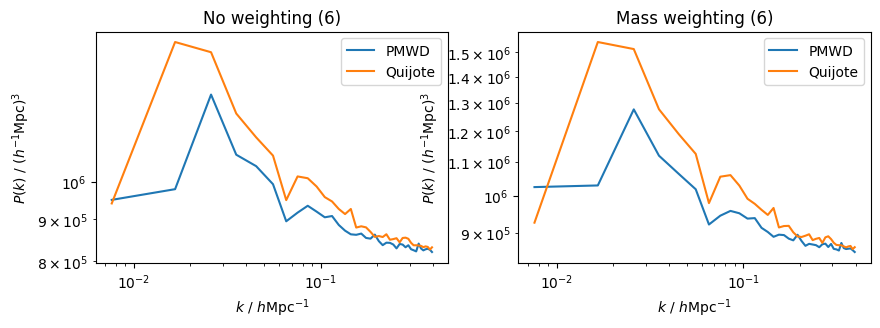

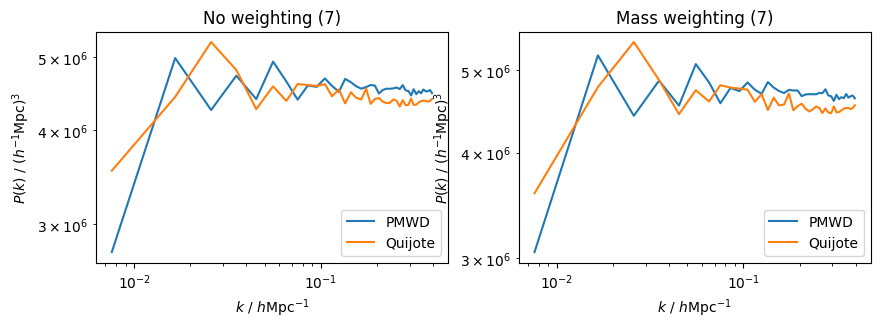

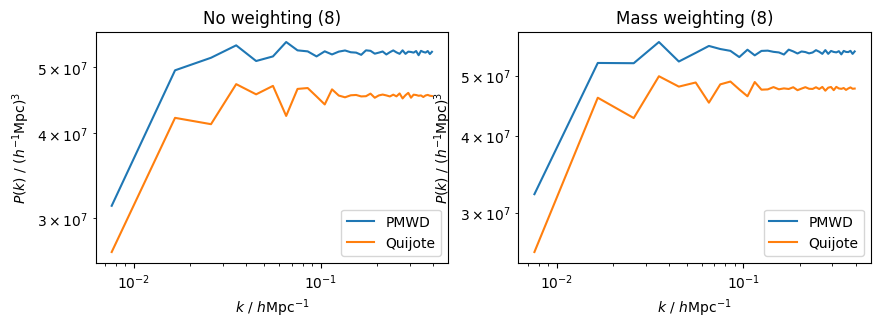

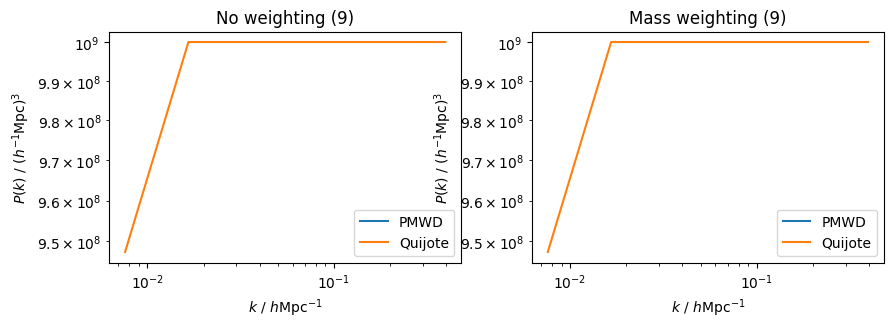

In [11]:
# borg_dirname = '/home/mattho/git/ltu-cmass/data/calib_1gpch_z0.5/borg2lpt/L1000-N128/'
borg_dirname = '/home/mattho/git/ltu-cmass/data/calib_1gpch_z0.5/pmwd/L1000-N128/'
quijote_dirname = '/data101/bartlett/quijote/Halos/latin_hypercube_HR/'
sim_num = 3

n_grid = 128
boxsize = 1000.
redshift = 0.5

# mmin = 10 ** 12.8; 
# mmax = 10 ** 15.8
# mmin = -1; 
# mmax = 1e300    

bin_num = 0
medges = np.load(pjoin(borg_dirname, str(sim_num), 'halo_medges.npy'))

for bin_num in tqdm(range(len(medges)-1)):
    
    mmin = 10 ** medges[bin_num]
    mmax = 10 ** medges[bin_num+1]
    
    fig, axs = plt.subplots(1, 2, figsize=(10,3))

    for ax, weight in zip(axs, [None, 'Mass']):

        reference = None

        for dirname, name, ls in zip([borg_dirname, quijote_dirname], ['PMWD', 'Quijote'], ['-', '--']):

            df_nbkit = {}

            x = np.load(pjoin(dirname, str(sim_num), 'halo_pos.npy'))
            mass = 10 ** np.load(pjoin(dirname, str(sim_num), 'halo_mass.npy'))
            # print(name, np.log10(mass.min()), np.log10(mass.max()))
            m = (mass >= mmin) & (mass <= mmax)
            x = x[m]
            mass = mass[m]
            # print('Number of halos:', len(x))

            # Nbodykit
            df_nbkit['Position'] = x
            df_nbkit['Mass'] = mass
            cat = ArrayCatalog(df_nbkit, BoxSize=boxsize)
            if weight is None:
                mesh_mock = cat.to_mesh(window='nearest', Nmesh=n_grid, compensated=False, position='Position')
            else:
                mesh_mock = cat.to_mesh(window='nearest', Nmesh=n_grid, compensated=False, position='Position', weight=weight)
            r = FFTPower(mesh_mock, mode='1d', dk=0.01)
            Pk_mock_nb = r.power
            ax.loglog(Pk_mock_nb['k'], Pk_mock_nb['power'].real, label=name, ls=ls)

        ax.set_xlabel(r'$k \ / \ h {\rm Mpc^{-1}}$')
        ax.set_ylabel(r'$P(k) \ / \ (h^{-1}{\rm Mpc})^3$')
        ax.legend()
        if weight is None:
            ax.set_title(f'No weighting ({bin_num})')
        else:
            ax.set_title(f'{str(weight)} weighting ({bin_num})')
            
        fig.tight_layout()

    # fig.savefig(f'pk_{weight}.png', bbox_inches='tight')


Halo mass function

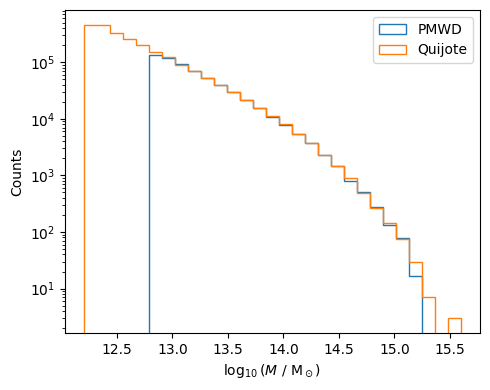

In [19]:
borg_dirname = '/home/mattho/git/ltu-cmass/data/calib_1gpch_z0.5/borg2lpt/L1000-N128/'
quijote_dirname = '/data101/bartlett/quijote/Halos/latin_hypercube_HR/'
sim_num = 3

fig, ax = plt.subplots(1, 1, figsize=(5,4))
hist_kwargs = {'bins':np.linspace(12.2, 15.6, 30), 'density':False, 'histtype':'step'}

for dirname, name in zip([borg_dirname, quijote_dirname], ['PMWD', 'Quijote']):
    mass = np.load(pjoin(dirname, str(sim_num), 'halo_mass.npy'))
    ax.hist(mass, label=name, **hist_kwargs)
    
ax.set_yscale('log')
# ax.set_title('Halo Mass Function')
ax.set_xlabel(r'$\log_{10} \left( M \ / \ {\rm M_\odot} \right)$')
ax.set_ylabel('Counts')
ax.legend()
fig.tight_layout()
fig.savefig('hmf.png')

In [25]:
medges = np.load('/home/mattho/git/ltu-cmass/data/calib_1gpch_z0.5/borg2lpt/L1000-N128/3/halo_medges.npy')
print(medges)

x = np.linspace(0, 1)
h, e = np.histogram(x, range=(0.5,0.7))
print(h.shape)
print(len(x), h.sum())

[12.8 13.1 13.4 13.7 14.  14.3 14.6 14.9 15.2 15.5 15.8]
(10,)
50 10


In [32]:
pos_h = np.load(pjoin(dirname, str(sim_num), 'halo_pos.npy'))
mass = 10 ** np.load(pjoin(dirname, str(sim_num), 'halo_mass.npy'))

mmin = 12.8
mmax = 15.8
# mmin = np.log10(mass.min())
# mmax = np.log10(mass.max())

L = 1000

N = 128
Nm = 10

posm = np.concatenate([pos_h, np.log10(mass)[:, None]], axis=1)
h, edges = np.histogramdd(
    posm,
    (N,)*3+(Nm,),
    range=[(0, L)]*3+[(mmin, mmax)]
)

print(posm.shape)
print(h.shape)
print(h.sum())

(2316312, 4)
(128, 128, 128, 10)
2316312.0


Plot the fields

Number of halos: 1327783


/tmp/ipykernel_244093/4201184850.py:24: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_mock = cat.to_mesh(window='nearest', Nmesh=n_grid, compensated=False, position='Position')


Number of halos: 1325811


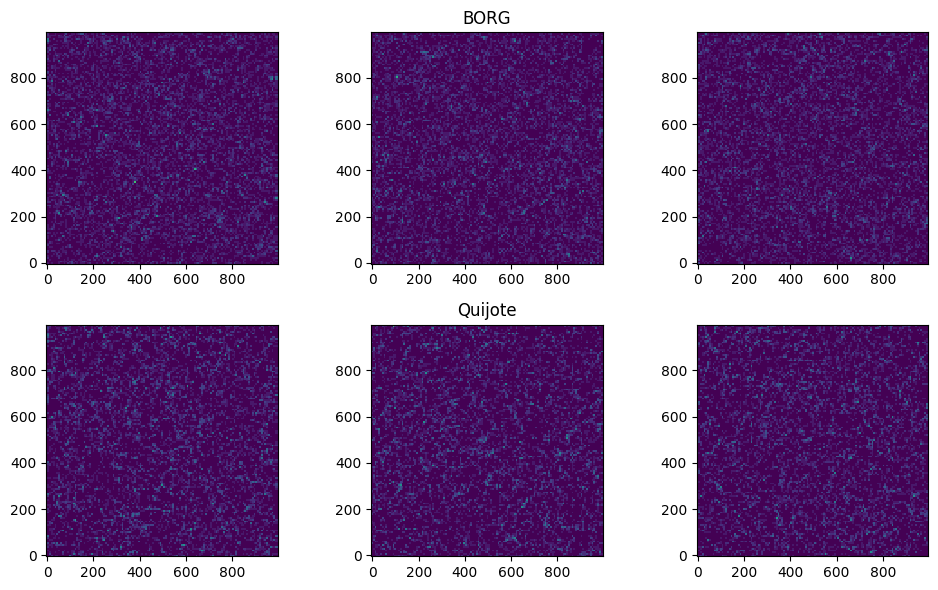

In [8]:
borg_dirname = '/home/mattho/git/ltu-cmass/data/calib_1gpch_z0.5/borg2lpt/L1000-N128/'
quijote_dirname = '/data101/bartlett/quijote/Halos/latin_hypercube_HR/'
sim_num = 136

n_grid = 128
boxsize = 1000.

vmin = None
vmax = None

fig, axs = plt.subplots(2, 3, figsize=(10,6))

for i, (dirname, name) in enumerate(zip([borg_dirname, quijote_dirname], ['BORG', 'Quijote'])):
    
    x = np.load(pjoin(dirname, str(sim_num), 'halo_pos.npy'))
    mass = 10 ** np.load(pjoin(dirname, str(sim_num), 'halo_mass.npy'))
    m = (mass >= mmin) & (mass <= mmax)
    x = x[m]
    print('Number of halos:', len(x))

    # Nbodykit
    df_nbkit['Position'] = x
    cat = ArrayCatalog(df_nbkit, BoxSize=boxsize)
    mesh_mock = cat.to_mesh(window='nearest', Nmesh=n_grid, compensated=False, position='Position')
    
    x = mesh_mock.to_field().x
    f = mesh_mock.to_field().value
    
    if vmin is None:
        vmin = f.min()
        vmax = f.max()
        
    N = f.shape[0]
    x0 = np.squeeze(x[0])
    x1 = np.squeeze(x[1])
    x2 = np.squeeze(x[2])
    x0[x0 < 0] += boxsize
    x1[x1 < 0] += boxsize
    x2[x2 < 0] += boxsize
    
    axs[i,0].pcolor(x0, x1, f[:,:,N//2], vmin=vmin, vmax=vmax)
    axs[i,1].pcolor(x0, x2, f[:,N//2,:], vmin=vmin, vmax=vmax)
    axs[i,2].pcolor(x1, x2, f[N//2,:,:], vmin=vmin, vmax=vmax)

axs[0,1].set_title('BORG')
axs[1,1].set_title('Quijote')
for ax in axs.flatten():
    ax.set_aspect('equal')
fig.tight_layout()

Check new sample

Number of halos: 1327783


/tmp/ipykernel_244093/3895849743.py:27: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_mock = cat.to_mesh(window='cic', Nmesh=n_grid, compensated=False, position='Position', weight='Mass')


Number of halos: 1328948
Number of halos: 1325811
Number of halos: 1327783


/tmp/ipykernel_244093/3895849743.py:25: DeprecationWarning: The window argument is deprecated. Use `resampler=` instead
  mesh_mock = cat.to_mesh(window='cic', Nmesh=n_grid, compensated=False, position='Position')


Number of halos: 1328948
Number of halos: 1325811
Old 8041
New 8049
Quijote 8043


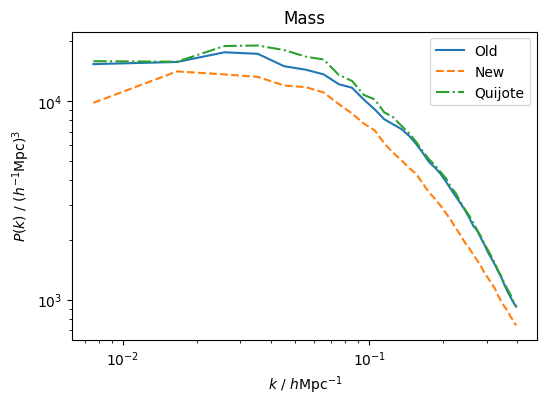

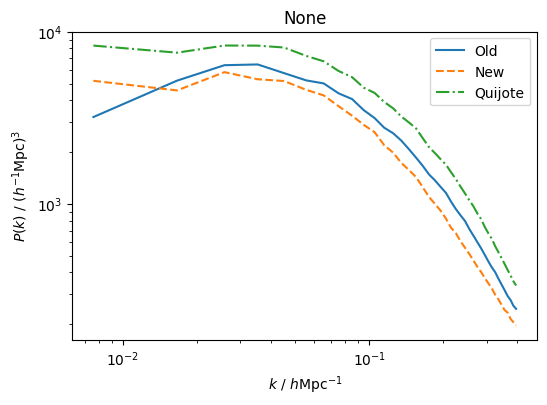

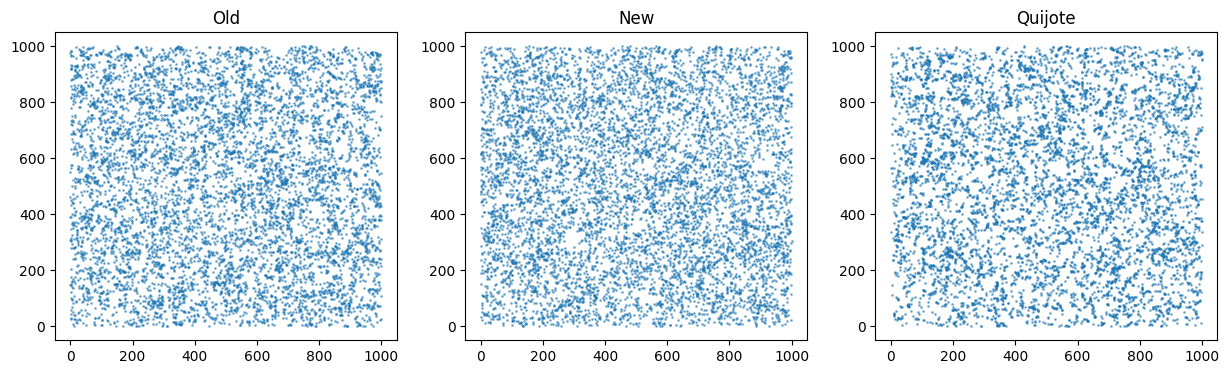

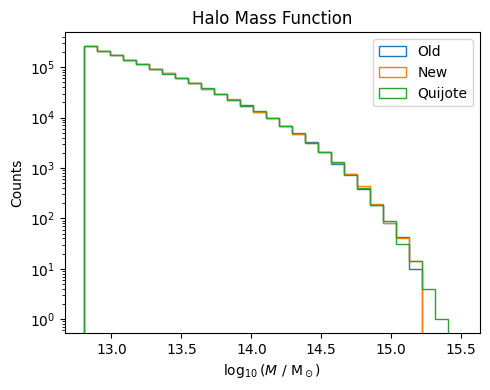

In [64]:
xnew = np.load('/home/bartlett/ili/xnew_136.npy')
xold = np.load('/home/bartlett/ili/xold_136.npy')
mnew = np.load('/home/bartlett/ili/mnew_136.npy')
mold = np.load('/home/bartlett/ili/mold_136.npy')

xquijote = np.load(pjoin('/data101/bartlett/quijote/Halos/latin_hypercube_HR/', '136', 'halo_pos.npy'))
mquijote = np.load(pjoin('/data101/bartlett/quijote/Halos/latin_hypercube_HR/', '136', 'halo_mass.npy'))
xquijote = xquijote[mquijote > 12.8]
mquijote = mquijote[mquijote > 12.8]
    
for weight in ['Mass', None]:

    fig, ax = plt.subplots(1, 1, figsize=(6,4))
    
    for x, mass, name, ls in zip([xold, xnew, xquijote], [mold, mnew, mquijote], ['Old', 'New', 'Quijote'], ['-', '--', '-.']):

        print('Number of halos:', len(x))

        # Nbodykit
        df_nbkit = {}
        df_nbkit['Position'] = x
        df_nbkit['Mass'] = 10 ** mass
        cat = ArrayCatalog(df_nbkit, BoxSize=boxsize)
        if weight is None:
            mesh_mock = cat.to_mesh(window='cic', Nmesh=n_grid, compensated=False, position='Position')
        else:
            mesh_mock = cat.to_mesh(window='cic', Nmesh=n_grid, compensated=False, position='Position', weight='Mass')
        r = FFTPower(mesh_mock, mode='1d', dk=0.01)
        Pk_mock_nb = r.power
        ax.loglog(Pk_mock_nb['k'], Pk_mock_nb['power'].real, label=name, ls=ls)
        ax.set_title(str(weight))

    ax.set_xlabel(r'$k \ / \ h {\rm Mpc^{-1}}$')
    ax.set_ylabel(r'$P(k) \ / \ (h^{-1}{\rm Mpc})^3$')
    ax.legend()

fig, axs = plt.subplots(1, 3, figsize=(15,4))
zli = [444, 450]
for ax, x, name in zip(axs, [xold, xnew, xquijote], ['Old', 'New', 'Quijote']):
    mask = (x[:,2] > zli[0]) & (x[:,2] < zli[1])
    print(name, mask.sum())
    x_ = x[mask]
    ax.plot(x_[:,0], x_[:,1], 'o', markersize=1, alpha=0.5)
    ax.set_title(name)
    

fig, ax = plt.subplots(1, 1, figsize=(5,4))
hist_kwargs = {'bins':np.linspace(12.8, 15.5, 30), 'density':False, 'histtype':'step'}
for mass, name in zip([mold, mnew, mquijote], ['Old', 'New', 'Quijote']):
    ax.hist(mass, label=name, **hist_kwargs)
    
ax.set_yscale('log')
ax.set_title('Halo Mass Function')
ax.set_xlabel(r'$\log_{10} \left( M \ / \ {\rm M_\odot} \right)$')
ax.set_ylabel('Counts')
ax.legend()
fig.tight_layout()